### Delft3D-FM animation
This script reads the map.nc file(s) and generates an animation (.gif). The user can select a specific time period. The following cells generate an animation of the entire domain and specific portions of Lake Seminole (with and without quiver). The script asks to select the directory of the simulation. In the animations of the entire domain and the Chattahoochee delta, the script reads the land boundary file $\texttt{delta\_island.ldb}$ to delineate the subaerial islands.

The script assumes that the simulation was run in DIMR configuration so the location has to point to the folder where the $\texttt{dflowfm}$ folder and $\texttt{dimr.xlm}$ file are. Specify if you want to consider the entire simulation (set $\texttt{entire\_simulation = Y}$) or a specific time window. The script creates a $\texttt{post\_processing}$ folder saves everything there.

NOTE 1: you need to specify the variable you want to animate, adjust the colorbar limits, colormap, and labels.

NOTE 2: for the most part, the script uses common python libraries. However, it also uses the $\href{https://github.com/Deltares/dfm_tools}{\texttt{dfm\_tools}}$ and $\href{https://github.com/Deltares/HYDROLIB-core}{\texttt{HYDROLIB-core}}$ packages by Deltares.

NOTE 3: depending on the lenght of the time period the animation can take a bit of time to generate.

In [2]:
# Load libraries and functions
import os
import datetime as dt
import numpy as np
import pandas as pd
import xarray as xr
import tkinter as tk
from tkinter import filedialog

# packages for Delft3D FM (by Deltares)
import hydrolib.core.dflowfm as hcdfm
import dfm_tools as dfmt

# Plotting settings
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['axes.titlesize'] = 14  # Title size
matplotlib.rcParams['axes.labelsize'] = 13  # Axis label size
matplotlib.rcParams['xtick.labelsize'] = 11  # X tick labels size
matplotlib.rcParams['ytick.labelsize'] = 11  # Y tick labels size
matplotlib.rcParams['legend.fontsize'] = 12  # Legend label size

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker
import contextily as ctx
import cmocean.cm as cmo
%matplotlib inline

def read_ldb(filename):
    """Read Delft3D .ldb file and return list of boundary polygons (as arrays of x,y).
    We use this function to deliniate the subaerial islands of the Chattahoochee delta
    """
    boundaries = []
    with open(filename, "r") as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        # Skip empty lines
        if not line:
            i += 1
            continue
        
        # Block starts with 'Fxxx'
        if line.startswith("F"):
            # Next line has rows and cols
            i += 1
            nrows, ncols = map(int, lines[i].split())
            
            coords = []
            for j in range(nrows):
                i += 1
                x, y = map(float, lines[i].split())
                coords.append((x, y))
            
            boundaries.append(coords)
        i += 1
    
    return boundaries

In [4]:
# --- SET TIME PERIOD ---
# Set entire_simulation = "Y" if you want to animate the entire period.  
# Otherwise, Set entire_simulation to anything else and specify the initial and last time
entire_simulation = None
tin               = '2023-08-18 00:00:00'
tend              = '2023-09-30 00:00:00'

In [5]:
# --- SELECT SIMULATION FOLDER ---
root = tk.Tk()
root.withdraw() # Hide the main Tkinter window

# --- Ask the user to select a file ---
folder_path  = filedialog.askdirectory(title="Select simulation directory")

if folder_path:
    print("Selected folder:", folder_path)
          
    # --- Create a folder where we save the figures and other post-processing stuff ---
    output_folder = os.path.join(folder_path, 'post_processing')
    os.makedirs(output_folder, exist_ok = True)
else:
    print("No folder selected.")

# --- Read the FlowFM_map.nc file ---
map_netcdf = os.path.join(folder_path, "dflowfm", "output", 'FlowFM_*_map.nc')
print("Reading:", map_netcdf)

# --- Open the netcdf ---
map_xr = dfmt.open_partitioned_dataset(map_netcdf)

# --- Select the time slice ---
t = map_xr.time
if entire_simulation == "Y":
    print("I will consider the entire simulation!")  
else:
    t = t.sel(time=slice(tin, tend))
    print("I will consider the time window:")
    print("Start time:", tin)
    print("Final time:", tend)

Selected folder: //researchdata/DVLdata/Snyderlab/LakeSeminole/Luca/SSC_weir_aug_oct2023_R17
Reading: //researchdata/DVLdata/Snyderlab/LakeSeminole/Luca/SSC_weir_aug_oct2023_R17\dflowfm\output\FlowFM_*_map.nc
>> xu.open_dataset() with 14 partition(s): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 : 91.65 sec
>> xu.merge_partitions() with 14 partition(s): 4.15 sec
>> dfmt.open_partitioned_dataset() total: 95.82 sec
I will consider the time window:
Start time: 2023-08-18 00:00:00
Final time: 2023-09-30 00:00:00


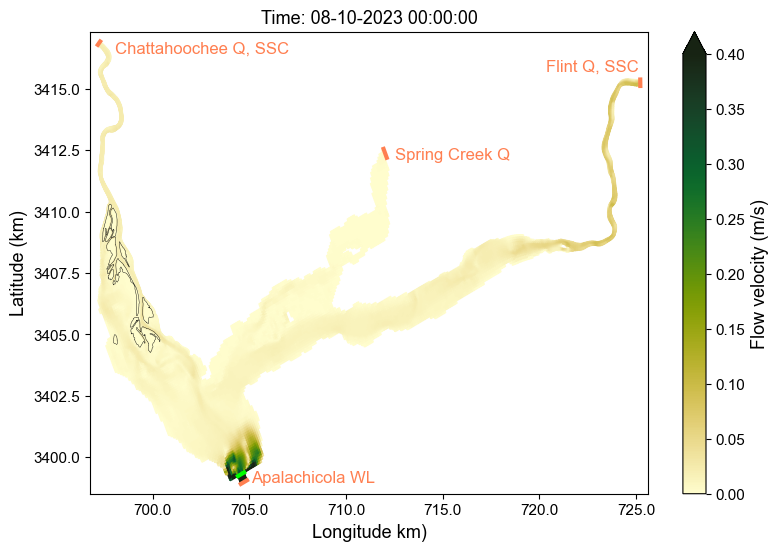

In [37]:
# --- ENTIRE DOMAIN ---
ldb_file = "delta_island.ldb"
islands  = read_ldb(ldb_file)

# Dam location
dam_lon_min = 704408.62512
dam_lon_max = 704724.73350
dam_lat_min = 3399229.59293
dam_lat_max = 3399376.92735

# Chattahoochee boundary
chatta_lon_min = 697156.0851305762
chatta_lon_max = 697277.4886592244
chatta_lat_min = 3416800.859368566
chatta_lat_max = 3416935.986774366

# Flint boundary
flint_lon_min = 725218.1543967176
flint_lon_max = 725222.5335256093
flint_lat_min = 3415386.776288251
flint_lat_max = 3415123.864337419

# Spring Creek boundary
spring_lon_min = 711939.7590172204
spring_lon_max = 712105.0789527535
spring_lat_min = 3412559.403485846
spring_lat_max = 3412199.120040133

# Apalachicola boundary
apa_lon_min = 704557.3391311469  
apa_lon_max = 704873.8950318663   
apa_lat_min = 3398911.143852373 
apa_lat_max = 3399058.880060460

# Get the min and max latitude/longitude
xmin = map_xr["mesh2d_node_x"].min().values 
xmax = map_xr["mesh2d_node_x"].max().values
ymin = map_xr["mesh2d_node_y"].min().values
ymax = map_xr["mesh2d_node_y"].max().values

# Create the animation of the selected variable:
# Set a few properties
c_min      = 0    # Minimum value
c_max      = 0.4  # Maximum value
variable   = 'mesh2d_ucmag'
magn_attrs = {'long_name':'Flow velocity', 'units':'m/s'}

# Select the time slice (if selected)
plot_data = map_xr.sel(time = t)

# Load a colormap and set the limit
cmap      = cmo.speed
umag_clim = (c_min, c_max)

# Extract the values (we need this for the animate function)
plot_array = plot_data[variable].values

fig, ax = plt.subplots(figsize=(9,6))

# Initial plot for the first frame (set up the plot object)
pc = plot_data.isel(time=0)[variable].ugrid.plot(ax=ax, cmap=cmap, add_colorbar=False)
pc.set_clim(umag_clim)

# Plot the islands boundaries
for coords in islands:
    xs, ys = zip(*coords)
    ax.plot(list(xs), list(ys), color="black", linewidth=0.3)

# Convert meters -> km directly in the tick formatter
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x/1000:.1f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y/1000:.1f}"))

# Axis, title, and colorbar customization:

ax.set_xlim([xmin - 400, xmax + 400])
ax.set_ylim([ymin - 400, ymax + 400])

ax.set_xlabel('Longitude (km)')
ax.set_ylabel('Latitude (km)')
ax.set_title('Time: %s'%(pd.to_datetime(t[0].values).strftime('%d-%m-%Y %H:%M:%S')))
fig.colorbar(pc, extend = 'max')
pc.colorbar.set_label(magn_attrs["long_name"] + ' (' + magn_attrs["units"] + ')', fontsize = 13)

# Plot a segment to highlight the dam and boundaries
ax.plot([dam_lon_min, dam_lon_max], [dam_lat_min, dam_lat_max], color='lime', linewidth=3)
ax.plot([apa_lon_min, apa_lon_max], [apa_lat_min, apa_lat_max], color='coral', linewidth=3)
ax.plot([chatta_lon_min, chatta_lon_max], [chatta_lat_min, chatta_lat_max], color='coral', linewidth=3)
ax.plot([flint_lon_min, flint_lon_max], [flint_lat_min, flint_lat_max], color='coral', linewidth=3)
ax.plot([spring_lon_min, spring_lon_max], [spring_lat_min, spring_lat_max], color='coral', linewidth=3)

ax.text(0.4, 0.05, 'Apalachicola WL', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

ax.text(0.2, 0.98, 'Chattahoochee Q, SSC', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

ax.text(0.9, 0.94, 'Flint Q, SSC', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

ax.text(0.65, 0.75, 'Spring Creek Q', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

def animate(i):
    # Update the magnitude and arrows for the current time step
    pc.set_array(plot_array[i].flatten())
    
    # Update time in the title
    ax.set_title('Time: %s'%(pd.to_datetime(t[i].values).strftime('%d-%m-%Y %H:%M:%S')))

    # Make sure axis labels are correct (maybe there is a smarter way to do this)
    ax.set_xlabel('Longitude km)')
    ax.set_ylabel('Latitude (km)')

    return (pc,)

ani = FuncAnimation(fig, animate, frames=len(t), interval=100, blit=True)

if zoom:
    ani_file = os.path.join(output_folder, variable + '_' + str(lon_min) + '_' + str(lat_min) + '.gif')
else:
    ani_file = os.path.join(output_folder, variable + '.gif')

ani.save(ani_file, writer='pillow', fps = 6, dpi=400)

>> rasterizing ugrid Dataset with 2 face variables to shape=(90,140): 0.63 sec


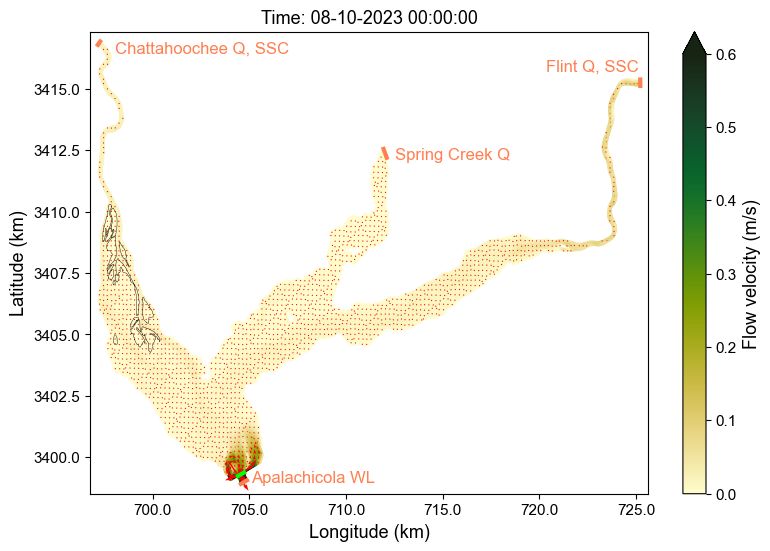

In [50]:
# --- ENTIRE DOMAIN WITH QUIVER ---
ldb_file = "delta_island.ldb"
islands  = read_ldb(ldb_file)

# Dam location
dam_lon_min = 704408.62512
dam_lon_max = 704724.73350
dam_lat_min = 3399229.59293
dam_lat_max = 3399376.92735

# Chattahoochee boundary
chatta_lon_min = 697156.0851305762
chatta_lon_max = 697277.4886592244
chatta_lat_min = 3416800.859368566
chatta_lat_max = 3416935.986774366

# Flint boundary
flint_lon_min = 725218.1543967176
flint_lon_max = 725222.5335256093
flint_lat_min = 3415386.776288251
flint_lat_max = 3415123.864337419

# Spring Creek boundary
spring_lon_min = 711939.7590172204
spring_lon_max = 712105.0789527535
spring_lat_min = 3412559.403485846
spring_lat_max = 3412199.120040133

# Apalachicola boundary
apa_lon_min = 704557.3391311469  
apa_lon_max = 704873.8950318663   
apa_lat_min = 3398911.143852373 
apa_lat_max = 3399058.880060460

# Get the min and max latitude/longitude
xmin = map_xr["mesh2d_node_x"].min().values 
xmax = map_xr["mesh2d_node_x"].max().values
ymin = map_xr["mesh2d_node_y"].min().values
ymax = map_xr["mesh2d_node_y"].max().values

# Create the animation of the selected variable:
# Set a few properties
c_min              = 0.0 # Minimum value
c_max              = 0.6 # Maximum value
varn_ucx, varn_ucy = 'mesh2d_ucx', 'mesh2d_ucy'
magn_attrs         = {'long_name':'Flow velocity', 'units':'m/s'}
rasterize_res      = 200
quiver_scale       = 30
quiver_color       = 'red'

# Select the time slice (if selected)
uds_quiv = map_xr.sel(time = t)

uds_quiv['magn'] = np.sqrt(uds_quiv[varn_ucx]**2+uds_quiv[varn_ucy]**2).assign_attrs(magn_attrs)
raster_quiv      = dfmt.rasterize_ugrid(uds_quiv[[varn_ucx,varn_ucy]], resolution=rasterize_res)

# Load a colormap and set the limit
cmap      = cmo.speed
umag_clim = (c_min, c_max)

fig, ax = plt.subplots(figsize=(9,6))

# Initial plot for the first frame (set up the plot object)
vel_magn = uds_quiv.isel(time=0)['mesh2d_ucmag'].ugrid.plot(ax=ax, cmap=cmap, add_colorbar=False)
vel_magn.set_clim(umag_clim)

# Add the quiver element (arrows)
qv = raster_quiv.isel(time=0).plot.quiver(ax=ax, x='mesh2d_face_x', y='mesh2d_face_y', u=varn_ucx, v=varn_ucy,
                                          color=quiver_color, scale=quiver_scale, add_guide=False)

# Plot the islands boundaries
for coords in islands:
    xs, ys = zip(*coords)
    ax.plot(list(xs), list(ys), color="black", linewidth=0.3)

# Convert meters → km directly in the tick formatter
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x/1000:.1f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y/1000:.1f}"))

# Axis and title customization:
ax.set_xlim([xmin - 400, xmax + 400])
ax.set_ylim([ymin - 400, ymax + 400])

ax.set_xlabel('Longitude (km)')
ax.set_ylabel('Latitude (km)')
ax.set_title('Time: %s'%(pd.to_datetime(t[0].values).strftime('%d-%m-%Y %H:%M:%S')))
fig.colorbar(vel_magn, extend = 'max', label=magn_attrs["long_name"] + ' (' + magn_attrs["units"] + ')')
#fig.colorbar.set_label(magn_attrs["long_name"] + ' (' + magn_attrs["units"] + ')', fontsize = 13)

# Plot a segment to highlight the dam and boundaries
ax.plot([dam_lon_min, dam_lon_max], [dam_lat_min, dam_lat_max], color='lime', linewidth=3)
ax.plot([apa_lon_min, apa_lon_max], [apa_lat_min, apa_lat_max], color='coral', linewidth=3)
ax.plot([chatta_lon_min, chatta_lon_max], [chatta_lat_min, chatta_lat_max], color='coral', linewidth=3)
ax.plot([flint_lon_min, flint_lon_max], [flint_lat_min, flint_lat_max], color='coral', linewidth=3)
ax.plot([spring_lon_min, spring_lon_max], [spring_lat_min, spring_lat_max], color='coral', linewidth=3)

ax.text(0.4, 0.05, 'Apalachicola WL', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

ax.text(0.2, 0.98, 'Chattahoochee Q, SSC', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

ax.text(0.9, 0.94, 'Flint Q, SSC', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

ax.text(0.65, 0.75, 'Spring Creek Q', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

def animate(time):
    # Update magnitude
    vel_magn.set_array(uds_quiv.isel(time=time)['mesh2d_ucmag'].values.flatten())

    # Update quiver
    qv.set_UVC(raster_quiv.isel(time=time)[varn_ucx].values, 
               raster_quiv.isel(time=time)[varn_ucy].values)
    
    # Update title
    ax.set_title('Time: %s' % pd.to_datetime(t[time].values).strftime('%d-%m-%Y %H:%M:%S'))

    return vel_magn, qv

ani = FuncAnimation(fig, animate, frames=5, interval=400, blit=False)

if zoom:
    ani_file = os.path.join(output_folder, 'flow_speed' + '_' + str(lon_min) + '_' + str(lat_min) + '_quiver.gif')
else:
    ani_file = os.path.join(output_folder, 'flow_speed_quiver.gif')

ani.save(ani_file, writer='pillow', fps = 4, dpi=400)

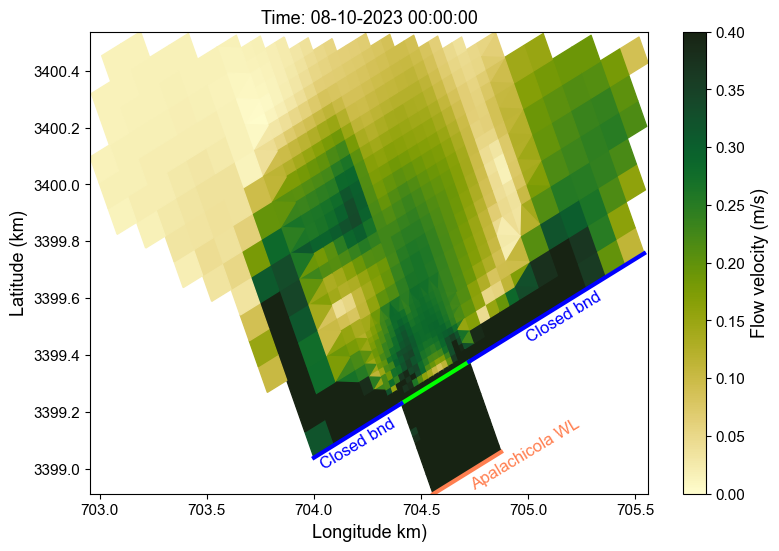

In [6]:
# --- NEAR WOODRUFF DAM ---
# Animation boundaries 
lon_min = 703000   # Min Longitude  
lon_max = 705500   # Max Longitude 
lat_min = 3397915  # Min Latitude 
lat_max = 3400500  # Max Latitude 

dam_lon_min = 704408.62512
dam_lon_max = 704724.73350
dam_lat_min = 3399229.59293
dam_lat_max = 3399376.92735

# Location of the close boundary
bnd_lon_min = 704000.73284
bnd_lat_min = 3399038.91642
bnd_lon_max = 705541.312309
bnd_lat_max = 3399757.4721

# Apalachicola boundary
apa_lon_min = 704557.3391311469  
apa_lon_max = 704873.8950318663   
apa_lat_min = 3398911.143852373 
apa_lat_max = 3399058.880060460

# Create the animation of the selected variable:
# Set a few properties
c_min      = 0   # Minimum value
c_max      = 0.4 # Maximum value
variable   = 'mesh2d_ucmag'
magn_attrs = {'long_name':'Flow velocity', 'units':'m/s'}

# Select the time slice (if selected)
plot_data = map_xr.sel(time = t)

# Cut to the specified area
plot_data = plot_data.ugrid.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))  

# Load a colormap and set the limit
cmap      = cmo.speed
umag_clim = (c_min, c_max)

# Extract the values (we need this for the animate function)
plot_array = plot_data[variable].values

fig, ax = plt.subplots(figsize=(9,6))

# Initial plot for the first frame (set up the plot object)
pc = plot_data.isel(time=0)[variable].ugrid.plot(ax=ax, cmap=cmap)
pc.set_clim(umag_clim)

# Convert meters → km directly in the tick formatter
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x/1000:.1f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y/1000:.1f}"))

# Axis, title, and colorbar customization:
ax.set_xlabel('Longitude (km)')
ax.set_ylabel('Latitude (km)')
ax.set_title('Time: %s'%(pd.to_datetime(t[0].values).strftime('%d-%m-%Y %H:%M:%S')))
pc.colorbar.set_label(magn_attrs["long_name"] + ' (' + magn_attrs["units"] + ')', fontsize = 13)

# Plot a segment to highlight the dam and boundaries
ax.plot([dam_lon_min, dam_lon_max], [dam_lat_min, dam_lat_max], color='lime', linewidth=3)
ax.plot([bnd_lon_min, dam_lon_min], [bnd_lat_min, dam_lat_min], color='blue', linewidth=3)
ax.plot([dam_lon_max, bnd_lon_max], [dam_lat_max, bnd_lat_max], color='blue', linewidth=3)
ax.plot([apa_lon_min, apa_lon_max], [apa_lat_min, apa_lat_max], color='coral', linewidth=3)

ax.text(0.48, 0.17, 'Closed bnd', color='blue', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)

ax.text(0.85, 0.445, 'Closed bnd', color='blue', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)

ax.text(0.78, 0.17, 'Apalachicola WL', color='coral', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)


def animate(i):
    # Update the magnitude and arrows for the current time step
    pc.set_array(plot_array[i].flatten())
    
    # Update time in the title
    ax.set_title('Time: %s'%(pd.to_datetime(t[i].values).strftime('%d-%m-%Y %H:%M:%S')))

    # Make sure axis labels are correct (maybe there is a smarter way to do this)
    ax.set_xlabel('Longitude km)')
    ax.set_ylabel('Latitude (km)')

    return (pc,)

#ani = FuncAnimation(fig, animate, frames=len(t), interval=100, blit=True)
ani = FuncAnimation(fig, animate, frames=10, interval=300, blit=False)

ani_file = os.path.join(output_folder, variable + '_near_dam.gif')

ani.save(ani_file, writer='pillow', fps = 6, dpi=400)

>> rasterizing ugrid Dataset with 2 face variables to shape=(13,21): 0.46 sec


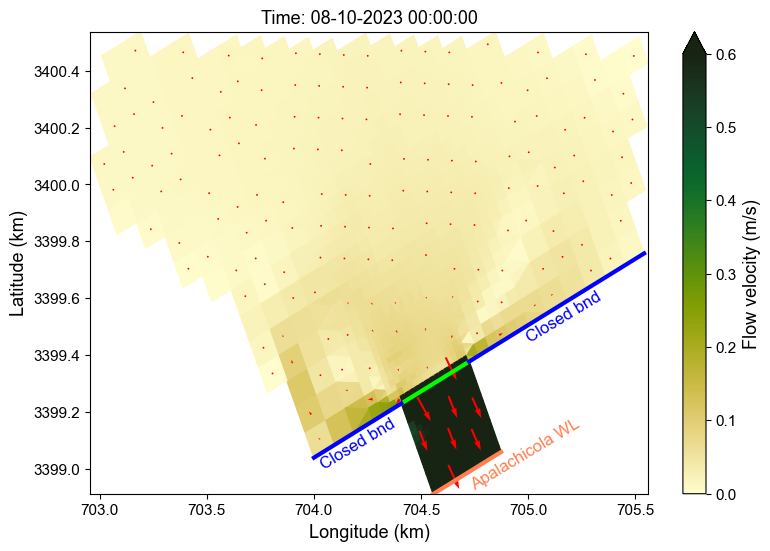

In [5]:
# --- NEAR WOODRUFF DAM WITH QUIVER ---
# Animation boundaries 
lon_min = 703000   # Min Longitude  
lon_max = 705500   # Max Longitude 
lat_min = 3397915  # Min Latitude 
lat_max = 3400500  # Max Latitude 

# Dam location
dam_lon_min = 704408.62512
dam_lon_max = 704724.73350
dam_lat_min = 3399229.59293
dam_lat_max = 3399376.92735

# Location of the close boundary
bnd_lon_min = 704000.73284
bnd_lat_min = 3399038.91642
bnd_lon_max = 705541.312309
bnd_lat_max = 3399757.4721

# Apalachicola boundary
apa_lon_min = 704557.3391311469  
apa_lon_max = 704873.8950318663   
apa_lat_min = 3398911.143852373 
apa_lat_max = 3399058.880060460

# Create the animation of the selected variable:
# Set a few properties
c_min              = 0.0 # Minimum value
c_max              = 0.6 # Maximum value
varn_ucx, varn_ucy = 'mesh2d_ucx', 'mesh2d_ucy'
magn_attrs         = {'long_name':'Flow velocity', 'units':'m/s'}
rasterize_res      = 125
quiver_scale       = 15
quiver_color       = 'red'

# Select the time slice (if selected)
uds_quiv = map_xr.sel(time = t)

# Cut to the specified area 
uds_quiv  = uds_quiv.ugrid.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))  

uds_quiv['magn'] = np.sqrt(uds_quiv[varn_ucx]**2+uds_quiv[varn_ucy]**2).assign_attrs(magn_attrs)
raster_quiv      = dfmt.rasterize_ugrid(uds_quiv[[varn_ucx,varn_ucy]], resolution=rasterize_res)

# Load a colormap and set the limit
cmap      = cmo.speed
umag_clim = (c_min, c_max)

fig, ax = plt.subplots(figsize=(9,6))

# Initial plot for the first frame (set up the plot object)
vel_magn = uds_quiv.isel(time=0)['mesh2d_ucmag'].ugrid.plot(ax=ax, cmap=cmap, add_colorbar=False)
vel_magn.set_clim(umag_clim)

# Add the quiver element (arrows)
qv = raster_quiv.isel(time=0).plot.quiver(ax=ax, x='mesh2d_face_x', y='mesh2d_face_y', u=varn_ucx, v=varn_ucy,
                                          color=quiver_color, scale=quiver_scale, add_guide=False)

# Convert meters → km directly in the tick formatter
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x/1000:.1f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y/1000:.1f}"))

# Axis and title customization:
ax.set_xlabel('Longitude (km)')
ax.set_ylabel('Latitude (km)')
ax.set_title('Time: %s'%(pd.to_datetime(t[0].values).strftime('%d-%m-%Y %H:%M:%S')))
fig.colorbar(vel_magn, extend = 'max', label=magn_attrs["long_name"] + ' (' + magn_attrs["units"] + ')')

# Plot a segment to highlight the dam and boundaries
ax.plot([dam_lon_min, dam_lon_max], [dam_lat_min, dam_lat_max], color='lime', linewidth=3)
ax.plot([bnd_lon_min, dam_lon_min], [bnd_lat_min, dam_lat_min], color='blue', linewidth=3)
ax.plot([dam_lon_max, bnd_lon_max], [dam_lat_max, bnd_lat_max], color='blue', linewidth=3)
ax.plot([apa_lon_min, apa_lon_max], [apa_lat_min, apa_lat_max], color='coral', linewidth=3)

ax.text(0.48, 0.17, 'Closed bnd', color='blue', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)

ax.text(0.85, 0.445, 'Closed bnd', color='blue', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)

ax.text(0.78, 0.17, 'Apalachicola WL', color='coral', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)

def animate(time):
    # Update magnitude
    vel_magn.set_array(uds_quiv.isel(time=time)['mesh2d_ucmag'].values.flatten())

    # Update quiver
    qv.set_UVC(raster_quiv.isel(time=time)[varn_ucx].values, 
               raster_quiv.isel(time=time)[varn_ucy].values)
    
    # Update title
    ax.set_title('Time: %s' % pd.to_datetime(t[time].values).strftime('%d-%m-%Y %H:%M:%S'))

    return vel_magn, qv

ani = FuncAnimation(fig, animate, frames=24, interval=400, blit=False)

ani_file = os.path.join(output_folder, variable + 'quiver_near_dam.gif')

ani.save(ani_file, writer='pillow', fps = 3, dpi=400)

In [7]:
# --- CHATTAHOOCHEE ARM DELTA ---
# Animation boundaries 
lon_min = 697000   # Min Longitude 
lon_max = 702500   # Max Longitude 
lat_min = 3404000  # Min Latitude 
lat_max = 3410000  # Max Latitude

ldb_file = "delta_island.ldb"
islands  = read_ldb(ldb_file)

# Create the animation of the selected variable:
# Set a few properties
c_min      = 0   # Minimum value
c_max      = 0.3 # Maximum value
variable   = 'mesh2d_ucmag'
magn_attrs = {'long_name':'Flow velocity', 'units':'m/s'}

# Select the time slice (if selected)
plot_data = map_xr.sel(time = t)

# Cut to the specified area
plot_data = plot_data.ugrid.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))  

# Load a colormap and set the limit
cmap      = cmo.speed
umag_clim = (c_min, c_max)

# Extract the values (we need this for the animate function)
plot_array = plot_data[variable].values

fig, ax = plt.subplots(figsize=(9,6))

# Initial plot for the first frame (set up the plot object)
pc = plot_data.isel(time=0)[variable].ugrid.plot(ax=ax, cmap=cmap, add_colorbar=False)
pc.set_clim(umag_clim)

# Plot the islands boundaries
for coords in islands:
    xs, ys = zip(*coords)
    ax.plot(list(xs), list(ys), color="black", linewidth=0.3)

# Convert meters -> km directly in the tick formatter
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x/1000:.1f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y/1000:.1f}"))

# Axis, title, and colorbar customization:
ax.set_xlabel('Longitude (km)')
ax.set_ylabel('Latitude (km)')
ax.set_title('Time: %s'%(pd.to_datetime(t[0].values).strftime('%d-%m-%Y %H:%M:%S')))
fig.colorbar(pc, extend = 'max')
pc.colorbar.set_label(magn_attrs["long_name"] + ' (' + magn_attrs["units"] + ')', fontsize = 13)

def animate(i):
    # Update the magnitude and arrows for the current time step
    pc.set_array(plot_array[i].flatten())
    
    # Update time in the title
    ax.set_title('Time: %s'%(pd.to_datetime(t[i].values).strftime('%d-%m-%Y %H:%M:%S')))

    # Make sure axis labels are correct (maybe there is a smarter way to do this)
    ax.set_xlabel('Longitude km)')
    ax.set_ylabel('Latitude (km)')

    return (pc,)

ani = FuncAnimation(fig, animate, frames=len(t), interval=100, blit=True)

ani_file = os.path.join(output_folder, variable + '_chattahoochee_delta.gif')

ani.save(ani_file, writer='pillow', fps = 6, dpi=400)

In [ ]:
# --- CHATTAHOOCHEE ARM DELTA WITH QUIVER ---
# Animation boundaries 
lon_min = 697500   # Min Longitude 
lon_max = 702500   # Max Longitude 
lat_min = 3404000  # Min Latitude 
lat_max = 3410000  # Max Latitude

ldb_file = "delta_island.ldb"
islands  = read_ldb(ldb_file)

# Create the animation of the selected variable:
# Set a few properties
c_min              = 0.0 # Minimum value
c_max              = 0.6 # Maximum value
varn_ucx, varn_ucy = 'mesh2d_ucx', 'mesh2d_ucy'
magn_attrs         = {'long_name':'Flow velocity', 'units':'m/s'}
rasterize_res      = 125
quiver_scale       = 15
quiver_color       = 'red'

# Select the time slice (if selected)
uds_quiv = map_xr.sel(time = t)

# Cut to the specified area 
uds_quiv  = uds_quiv.ugrid.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))  

uds_quiv['magn'] = np.sqrt(uds_quiv[varn_ucx]**2+uds_quiv[varn_ucy]**2).assign_attrs(magn_attrs)
raster_quiv      = dfmt.rasterize_ugrid(uds_quiv[[varn_ucx,varn_ucy]], resolution=rasterize_res)

# Load a colormap and set the limit
cmap      = cmo.speed
umag_clim = (c_min, c_max)

fig, ax = plt.subplots(figsize=(9,6))

# Initial plot for the first frame (set up the plot object)
vel_magn = uds_quiv.isel(time=0)['mesh2d_ucmag'].ugrid.plot(ax=ax, cmap=cmap, add_colorbar=False)
vel_magn.set_clim(umag_clim)

# Plot the islands boundaries
for coords in islands:
    xs, ys = zip(*coords)
    ax.plot(list(xs), list(ys), color="black", linewidth=0.3)

# Add the quiver element (arrows)
qv = raster_quiv.isel(time=0).plot.quiver(ax=ax, x='mesh2d_face_x', y='mesh2d_face_y', u=varn_ucx, v=varn_ucy,
                                          color=quiver_color, scale=quiver_scale, add_guide=False)

# Convert meters → km directly in the tick formatter
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x/1000:.1f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y/1000:.1f}"))

# Axis and title customization:
ax.set_xlabel('Longitude (km)')
ax.set_ylabel('Latitude (km)')
ax.set_title('Time: %s'%(pd.to_datetime(t[0].values).strftime('%d-%m-%Y %H:%M:%S')))
fig.colorbar(vel_magn, extend = 'max', label=magn_attrs["long_name"] + ' (' + magn_attrs["units"] + ')')

# Plot a segment to highlight the dam and boundaries
ax.plot([dam_lon_min, dam_lon_max], [dam_lat_min, dam_lat_max], color='lime', linewidth=3)
ax.plot([bnd_lon_min, dam_lon_min], [bnd_lat_min, dam_lat_min], color='blue', linewidth=3)
ax.plot([dam_lon_max, bnd_lon_max], [dam_lat_max, bnd_lat_max], color='blue', linewidth=3)
ax.plot([apa_lon_min, apa_lon_max], [apa_lat_min, apa_lat_max], color='coral', linewidth=3)

ax.text(0.48, 0.17, 'Closed bnd', color='blue', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)

ax.text(0.85, 0.445, 'Closed bnd', color='blue', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)

ax.text(0.78, 0.17, 'Apalachicola WL', color='coral', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)

def animate(time):
    # Update magnitude
    vel_magn.set_array(uds_quiv.isel(time=time)['mesh2d_ucmag'].values.flatten())

    # Update quiver
    qv.set_UVC(raster_quiv.isel(time=time)[varn_ucx].values, 
               raster_quiv.isel(time=time)[varn_ucy].values)
    
    # Update title
    ax.set_title('Time: %s' % pd.to_datetime(t[time].values).strftime('%d-%m-%Y %H:%M:%S'))

    return vel_magn, qv

ani = FuncAnimation(fig, animate, frames=len(t), interval=400, blit=False)

ani_file = os.path.join(output_folder, variable + 'quiver_chattahoochee_delta.gif')

ani.save(ani_file, writer='pillow', fps = 3, dpi=400)

In [6]:
# --- ENTIRE DOMAIN SSC (select the sed fraction) ---
ldb_file = "delta_island.ldb"
islands  = read_ldb(ldb_file)

# Dam location
dam_lon_min = 704408.62512
dam_lon_max = 704724.73350
dam_lat_min = 3399229.59293
dam_lat_max = 3399376.92735

# Chattahoochee boundary
chatta_lon_min = 697156.0851305762
chatta_lon_max = 697277.4886592244
chatta_lat_min = 3416800.859368566
chatta_lat_max = 3416935.986774366

# Flint boundary
flint_lon_min = 725218.1543967176
flint_lon_max = 725222.5335256093
flint_lat_min = 3415386.776288251
flint_lat_max = 3415123.864337419

# Spring Creek boundary
spring_lon_min = 711939.7590172204
spring_lon_max = 712105.0789527535
spring_lat_min = 3412559.403485846
spring_lat_max = 3412199.120040133

# Apalachicola boundary
apa_lon_min = 704557.3391311469  
apa_lon_max = 704873.8950318663   
apa_lat_min = 3398911.143852373 
apa_lat_max = 3399058.880060460

# Get the min and max latitude/longitude
xmin = map_xr["mesh2d_node_x"].min().values 
xmax = map_xr["mesh2d_node_x"].max().values
ymin = map_xr["mesh2d_node_y"].min().values
ymax = map_xr["mesh2d_node_y"].max().values


# =============  Set a few properties =======================
fraction_name = "clay"
c_min      = 0   # Minimum value
c_max      = 0.005 # Maximum value
variable   = 'mesh2d_sedfrac_concentration'
magn_attrs = {'long_name': f'Suspended Sediment Concentration ({fraction_name})', 'units': '$kg/m^3$'}
# ==========================================================

# Get its index
sed_names = [name.decode('utf-8') for name in map_xr["sedfrac_name"].values]
i_frac = sed_names.index(fraction_name)

# Select the time slice (if selected) and sediment fraction
plot_data = map_xr["mesh2d_sedfrac_concentration"].sel(time = t, nSedSus=i_frac)

# Load a colormap and set the limit
cmap      = cmo.turbid
umag_clim = (c_min, c_max)

# Extract the values (we need this for the animate function)
plot_array = plot_data.values

fig, ax = plt.subplots(figsize=(9,6))

# Initial plot for the first frame (set up the plot object)
pc = plot_data.isel(time=0).ugrid.plot(ax=ax, cmap=cmap, add_colorbar=False)
pc.set_clim(umag_clim)

# Plot the islands boundaries
for coords in islands:
    xs, ys = zip(*coords)
    ax.plot(list(xs), list(ys), color="black", linewidth=0.3)

# Convert meters → km directly in the tick formatter
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x/1000:.1f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y/1000:.1f}"))

# Axis, title, and colorbar customization:

ax.set_xlim([xmin - 400, xmax + 400])
ax.set_ylim([ymin - 400, ymax + 400])

ax.set_xlabel('Longitude (km)')
ax.set_ylabel('Latitude (km)')
ax.set_title('Time: %s'%(pd.to_datetime(t[0].values).strftime('%d-%m-%Y %H:%M:%S')))
fig.colorbar(pc, extend = 'max')
pc.colorbar.set_label(magn_attrs["long_name"] + ' (' + magn_attrs["units"] + ')', fontsize = 13)

# Plot a segment to highlight the dam and boundaries
ax.plot([dam_lon_min, dam_lon_max], [dam_lat_min, dam_lat_max], color='lime', linewidth=3)
ax.plot([apa_lon_min, apa_lon_max], [apa_lat_min, apa_lat_max], color='coral', linewidth=3)
ax.plot([chatta_lon_min, chatta_lon_max], [chatta_lat_min, chatta_lat_max], color='coral', linewidth=3)
ax.plot([flint_lon_min, flint_lon_max], [flint_lat_min, flint_lat_max], color='coral', linewidth=3)
ax.plot([spring_lon_min, spring_lon_max], [spring_lat_min, spring_lat_max], color='coral', linewidth=3)

ax.text(0.4, 0.05, 'Apalachicola WL', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

ax.text(0.2, 0.98, 'Chattahoochee Q, SSC', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

ax.text(0.9, 0.94, 'Flint Q, SSC', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

ax.text(0.65, 0.75, 'Spring Creek Q', color='coral', fontsize=12, 
        ha='center', va='top', transform=ax.transAxes)

def animate(i):
    # Update the magnitude and arrows for the current time step
    pc.set_array(plot_array[i].flatten())
    
    # Update time in the title
    ax.set_title('Time: %s'%(pd.to_datetime(t[i].values).strftime('%d-%m-%Y %H:%M:%S')))

    # Make sure axis labels are correct (maybe there is a smarter way to do this)
    ax.set_xlabel('Longitude km)')
    ax.set_ylabel('Latitude (km)')

    return (pc,)

ani = FuncAnimation(fig, animate, frames=len(t), interval=100, blit=True)

ani_file = os.path.join(output_folder, variable + '_' + fraction_name + '.gif')

ani.save(ani_file, writer='pillow', fps = 6, dpi=400)

In [17]:
# --- NEAR WOODRUFF DAM SSC (select the sed fraction) ---
plot_data = None

# Animation boundaries 
lon_min = 703000   # Min Longitude  
lon_max = 705500   # Max Longitude 
lat_min = 3397915  # Min Latitude 
lat_max = 3400500  # Max Latitude 

dam_lon_min = 704408.62512
dam_lon_max = 704724.73350
dam_lat_min = 3399229.59293
dam_lat_max = 3399376.92735

# Location of the close boundary
bnd_lon_min = 704000.73284
bnd_lat_min = 3399038.91642
bnd_lon_max = 705541.312309
bnd_lat_max = 3399757.4721

# Apalachicola boundary
apa_lon_min = 704557.3391311469  
apa_lon_max = 704873.8950318663   
apa_lat_min = 3398911.143852373 
apa_lat_max = 3399058.880060460

# =============  Set a few properties =======================
fraction_name = "clay"
c_min      = 0   # Minimum value
c_max      = 0.1 # Maximum value
variable   = 'mesh2d_sedfrac_concentration'
magn_attrs = {'long_name': f'Suspended Sediment Concentration ({fraction_name})', 'units': '$kg/m^3$'}
# ==========================================================

# Get its index
sed_names = [name.decode('utf-8') for name in map_xr["sedfrac_name"].values]
i_frac = sed_names.index(fraction_name)

# Select the time slice (if selected) and sediment fraction
plot_data = map_xr["mesh2d_sedfrac_concentration"].sel(time = t, nSedSus=i_frac)

# Cut to the specified area
plot_data = plot_data.ugrid.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))  

# Load a colormap and set the limit
cmap      = cmo.turbid
umag_clim = (c_min, c_max)

# Extract the values (we need this for the animate function)
plot_array = plot_data.values

fig, ax = plt.subplots(figsize=(9,6))

# Initial plot for the first frame (set up the plot object)
pc = plot_data.isel(time=0).ugrid.plot(ax=ax, cmap=cmap, add_colorbar=False)
pc.set_clim(umag_clim)

# Convert meters → km directly in the tick formatter
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x/1000:.1f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y/1000:.1f}"))

# Axis, title, and colorbar customization:
ax.set_xlabel('Longitude (km)')
ax.set_ylabel('Latitude (km)')
ax.set_title('Time: %s'%(pd.to_datetime(t[0].values).strftime('%d-%m-%Y %H:%M:%S')))
fig.colorbar(pc, extend = 'max')
pc.colorbar.set_label(magn_attrs["long_name"] + ' (' + magn_attrs["units"] + ')', fontsize = 13)

# Plot a segment to highlight the dam and boundaries
ax.plot([dam_lon_min, dam_lon_max], [dam_lat_min, dam_lat_max], color='lime', linewidth=3)
ax.plot([bnd_lon_min, dam_lon_min], [bnd_lat_min, dam_lat_min], color='blue', linewidth=3)
ax.plot([dam_lon_max, bnd_lon_max], [dam_lat_max, bnd_lat_max], color='blue', linewidth=3)
ax.plot([apa_lon_min, apa_lon_max], [apa_lat_min, apa_lat_max], color='coral', linewidth=3)

ax.text(0.48, 0.17, 'Closed bnd', color='blue', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)

ax.text(0.85, 0.445, 'Closed bnd', color='blue', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)

ax.text(0.78, 0.17, 'Apalachicola WL', color='coral', fontsize=12, 
        ha='center', va='top', rotation=31, transform=ax.transAxes)

def animate(i):
    # Update the magnitude and arrows for the current time step
    pc.set_array(plot_array[i].flatten())
    
    # Update time in the title
    ax.set_title('Time: %s'%(pd.to_datetime(t[i].values).strftime('%d-%m-%Y %H:%M:%S')))

    # Make sure axis labels are correct (maybe there is a smarter way to do this)
    ax.set_xlabel('Longitude km)')
    ax.set_ylabel('Latitude (km)')

    return (pc,)

ani = FuncAnimation(fig, animate, frames=len(t), interval=100, blit=True)

ani_file = os.path.join(output_folder, variable + '_' + fraction_name + '_near_dam.gif')

ani.save(ani_file, writer='pillow', fps = 6, dpi=400)